<h1><center>
    Eyetracking: Experiment Design and Machine Learning Methods<br/>
  
    
    Assignment 6
</center></h1>

### In assignment 6, we will work with ~~Tensorflow~~ Pytorch to use a CNN.

**The deadline for submitting your implementation is 25 May, 10.15 a.m. Please upload your solution as a pre-compiled jupyter notebook to OLAT**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import torch
from tqdm import trange, tqdm

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Please check that you're working with ~~Tensorflow 2.x~~. You're also free to use pytorch or any other DL framework.

The assignment is structure in the following way: Load the data, explore the data, preprocess the data, define your network, train your network, evaluate your network.
This is basically a dress rehearsal for the second project. 

# Task 1

Load GazeBase dataset: https://figshare.com/articles/dataset/GazeBase_Data_Repository/12912257

You already know this dataset from the assignment 'getting to know the data'. Here is the paper introducing the dataset: https://www.nature.com/articles/s41597-021-00959-ybut. To recap: there are up to 322 subjects, several different tasks and 9 rounds with two sessions for each task. 

Decide for one subtask and state a problem-setting you want to investigate using a CNN. As in the exercise two weeks ago the results do not need to be above random guessing, it is only about the execution. NOTE: the dataset (subtask) you're using in this assignment is then excluded from the final project. But if you want to use another task of GazeBase and a CNN the pipeline should be easily adjustable.

In [ ]:
#############################
#                           #
#        Load the data      #
#                           #
#############################

# There is no need to use python 'requests' library to load the data
# Direct download and then unzip the file seems to be the fastest
# Begin running the following codes after all the compressed files
# are unzipped (recursively!)

# Remove irrelevant data
pwd = './'

for r in trange(1, 10):
    round_path = pwd + f'Round_{r}/'
    for subject_name in os.listdir(round_path):
        subject_path = round_path + subject_name + '/'
        if not os.path.isdir(subject_path):
            continue
        for session in os.listdir(subject_path):
            session_path = subject_path + session + '/'
            if not os.path.isdir(session_path):
                continue
            for subtask in os.listdir(session_path):
                subtask_path = session_path + subtask + '/'
                if subtask[-7:] == 'Reading':
                    os.system('mv ' + subtask_path + '*.csv ' + subject_path)
                    os.system('rm ' + subtask_path)
                else:
                    os.system('rm ' + subtask_path)
            os.system('rm -r ' + session_path)

100%|██████████| 9/9 [01:52<00:00, 12.49s/it]


In [ ]:
# gather all the data
for r in trange(1, 10):
    round_path = pwd + f'Round_{r}/'
    for subject_name in os.listdir(round_path):
        subject_path = round_path + subject_name + '/'
        if not os.path.isdir(subject_path):
            continue     
        os.system('mv ' + subject_path + '*.csv ' + round_path)
        os.system('rm -r ' + subject_path)

100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


In [ ]:
# put all data together as raw data
for r in trange(1, 10):
    round_path = pwd + f'Round_{r}/'
    os.system('mv ' + round_path + '*.csv ./raw')
    os.system('rm -r ' + round_path)

100%|██████████| 9/9 [00:00<00:00, 57.68it/s]


# Task 2

State your problem setting below. Describe at least which architecture you are using, what its goal is, the format of the input data and labels and from where you got the data. For an example problem setting see e.g. [Jäger et al](https://arxiv.org/pdf/1906.11889.pdf).

# Task 3

Do basic data exploration (e.g. checking for nans, visualization, units and range of the data,...)

It would make sense to first extract the data from the files and store it in a suitable format for further processing, e.g. in a feature matrix and a label vector

In [ ]:
############################################
#                                          #
#        Your exploration starts here      #
#                                          #
############################################
df = pd.read_csv('./raw/S_1001_S1_TEX.csv', index_col='n')
df

,x,y,val,dP,lab,xT,yT
n,,,,,,,
0,-15.275756,3.629150,0,2190.0,0,NaN,NaN
1,-15.283961,3.640889,0,2190.0,0,NaN,NaN
2,-15.289431,3.658497,0,2190.0,0,NaN,NaN
3,-15.297635,3.664366,0,2190.0,0,NaN,NaN
4,-15.300369,3.667301,0,2190.0,0,NaN,NaN
...,...,...,...,...,...,...,...
60228,1.172577,0.973101,0,1459.0,1,NaN,NaN
60229,1.166701,0.949535,0,1460.0,1,NaN,NaN
60230,1.163763,0.925968,0,1460.0,1,NaN,NaN


In [ ]:
df.describe()

,x,y,val,dP,lab,xT,yT
count,58228.000000,58228.000000,60233.00000,58228.000000,60233.000000,0.0,0.0
mean,-0.240258,-1.150428,0.13315,1492.359964,1.038567,NaN,NaN
std,5.062450,8.722335,0.71755,199.492512,0.495621,NaN,NaN
min,-31.959825,-19.513322,0.00000,164.000000,-1.000000,NaN,NaN
25%,-4.458561,-7.968180,0.00000,1352.000000,1.000000,NaN,NaN
50%,-0.449688,1.049690,0.00000,1460.000000,1.000000,NaN,NaN
75%,3.021631,6.391936,0.00000,1593.000000,1.000000,NaN,NaN
max,47.060899,31.006217,4.00000,2491.000000,2.000000,NaN,NaN


In [ ]:
df = df.drop(['xT', 'yT'], axis=1).fillna(0).drop(['val'], axis=1)
df

,x,y,dP,lab
n,,,,
0,-15.275756,3.629150,2190.0,0
1,-15.283961,3.640889,2190.0,0
2,-15.289431,3.658497,2190.0,0
3,-15.297635,3.664366,2190.0,0
4,-15.300369,3.667301,2190.0,0
...,...,...,...,...
60228,1.172577,0.973101,1459.0,1
60229,1.166701,0.949535,1460.0,1
60230,1.163763,0.925968,1460.0,1


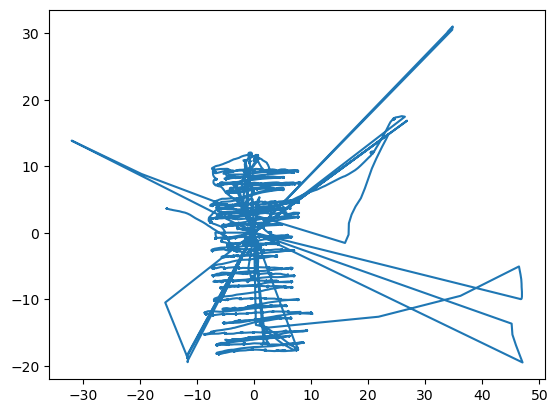

In [ ]:
plt.plot(df['x'], df['y'])
plt.show()

In [ ]:
# preprocessing
for f in tqdm(os.listdir('./raw/')):
    m = re.match(r'S_(\d)(\d{3})_S(\d)_TEX', f)
    if m:
        df = pd.read_csv('./raw/' + f, index_col='n')
        df = df.drop(['xT', 'yT'], axis=1).fillna(0).drop(['val'], axis=1)
        df.to_csv(f'./interim/{m.group(2)}_{m.group(1)}_{m.group(3)}.csv')
        
os.system('rm -r ./raw')

100%|██████████| 1758/1758 [06:36<00:00,  4.43it/s]


In [ ]:
df = pd.read_excel('./GazeBaseDemoInfo.xlsx')
df = df[['Participant ID', 'Self-Identified Gender']].rename({'Participant ID':'id', 'Self-Identified Gender':'gender'}, axis=1)
df['gender'] = df['gender'].map({'Male':0, 'male':0, 'Female':1})
df
df.to_csv('./interim/gender.csv', index=False)

In [ ]:
# So the dataset is not unbalanced
print('male count:',   len(df[df['gender'] == 0].index), sep='\t')
print('female count:', len(df[df['gender'] == 1].index), sep='\t')

male count:	170
female count:	151


# Task 4

Split the data into train and test split. We've already done something similar in assignment 5.
<br>
* Read in the unzipped files and store the data in a feature matrix and a label vector (partially done in Task 1 \& 3)
* Do some data exploration on both the features and the labels (partially done in Task 3)
* Preprocess the labels by one-hot-encoding
* You will need to reshape your feature matrix to work as an input for the CNN
* Pad the feature matrix
* Split the data into train and test sets



In [6]:
##########################################
#                                        #
#       Your splitting                   #
#                                        #
##########################################
record_list = [str(x) for x in os.listdir('/content/drive/MyDrive/ET/interim/') if x[-3:] == 'csv' and x[0] != 'g']
data_index = pd.DataFrame({'x': record_list, 'id': [int(x[:3]) for x in record_list]})
df_y_lookup = pd.read_csv('/content/drive/MyDrive/ET/interim/gender.csv')
data_index = data_index.merge(df_y_lookup, on='id', how='left').drop('id', axis=1)
data_index['male'] = (data_index['gender'] == 0).astype(int)
data_index['female'] = (data_index['gender'] == 1).astype(int)
data_index = data_index.drop('gender', axis=1)
data_index

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_index['x'], data_index[['male', 'female']], test_size=0.2)

In [ ]:
for x in tqdm(X_train):
    os.system('mv ./interim/' + x + ' ./processed/X_train')

for x in tqdm(X_test):
    os.system('mv ./interim/' + x + ' ./processed/X_test')

100%|██████████| 352/352 [00:02<00:00, 124.77it/s]


# Task 5

Preprocess your data. This is not always necessary, however, note that using a full sequence as input can be very computationally intensive. This can be counteracted by downsampling or splitting. Splitting in this case means to only use a subsequence of the data, e.g., a few seconds, as input.

In [24]:
class MyData(torch.utils.data.Dataset):
    def __init__(self, datapath, transform=None, downsampling=128):
        self.csvs_dir = datapath 
        self.csv_list = os.listdir(datapath)
        self.label_lookup = pd.read_csv('/content/drive/MyDrive/ET/processed/gender.csv')
        self.transform = transform
        self.downsampling = downsampling
        
    def __getitem__(self, index):
        csv_name = self.csv_list[index]
        
        if (self.label_lookup[self.label_lookup['id'] == int(csv_name[:3])]['gender'] == 0).any():
#             label = torch.tensor([1, 0])
            label = 0
        else:
#             label = torch.tensor([0, 1])
            label = 1
            
        df = pd.read_csv(self.csvs_dir + csv_name, index_col='n')
        raw_tensor = torch.tensor(df.values)
        x_tensor = torch.transpose(raw_tensor[np.linspace(0, raw_tensor.shape[0]-1, self.downsampling).astype(int), :], 0, 1)
        
        if self.transform:
            x_tensor = self.transform(x_tensor)
        
        return x_tensor, label
        
    def __len__(self):
        return len(self.csv_list)
    
    
batchsize = 16

train_dataset = MyData('/content/drive/MyDrive/ET/processed/X_train/')
test_dataset  = MyData('/content/drive/MyDrive/ET/processed/X_test/')
all_dataset  = MyData('/content/drive/MyDrive/ET/processed/X_all/')

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(dataset=test_dataset , batch_size=batchsize, shuffle=True)
all_dataloader  = torch.utils.data.DataLoader(dataset=all_dataset , batch_size=batchsize, shuffle=True)

# Task 6

Define your convolutional neural network.

The simplest way to define a model is as a sequential model. In the list you stack the layers you want to use. Feel free to use other possibilities to define your model.

In [26]:
############################################
#                                          #
#     Your model definition goes here      #
#                                          #
############################################
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.L1 = torch.nn.Conv1d(4, 4, 7).double()
        self.L2 = torch.nn.Conv1d(4, 2, 15).double()
        self.L3 = torch.nn.MaxPool1d(4)
        self.L4 = torch.nn.Flatten()
        
        self.L5a = torch.nn.Linear(54, 32).double()
        self.L5b = torch.nn.ReLU()
        self.L5c = torch.nn.Dropout(p=0.2)
        
        self.L6a = torch.nn.Linear(32, 32).double()
        self.L6b = torch.nn.ReLU()
        self.L6c = torch.nn.Dropout(p=0.2)
        
        self.L7a = torch.nn.Linear(32, 32).double()
        self.L7b = torch.nn.ReLU()
        self.L7c = torch.nn.Dropout(p=0.2)
        
        self.L8a = torch.nn.Linear(32, 2).double()
        
        
    def forward(self, x):
        x = self.L1(x)
        x = self.L2(x)
        x = self.L3(x)
        x = self.L4(x)
        x = self.L5c(self.L5b(self.L5a(x)))
        x = self.L6c(self.L6b(self.L6a(x)))
        x = self.L7c(self.L7b(self.L7a(x)))
        x = self.L8a(x)
        
        return x

# Task 7

Compile your model. For that read the documentation on `model.compile(*args, **kwargs)`. You'll need at least an optimizer and a loss function.

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
model = MyModel().to(device)  

# Task 8

Fit and test your model using `model.fit()` and `model.predict()`. If needed consult the documentation. Typically you provide the dataset, batch size, and number of epochs. You test your model on the test set defined above. 

In [20]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device):

    model.eval() 
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    results = {"train_loss": [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc"  : []
              }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

        print(f"Epoch: {epoch+1} | ", f"train_loss: {train_loss:.4f} | ", f"train_acc: {train_acc:.4f} | ", f"test_loss: {test_loss:.4f} | ", f"test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [33]:
history = train(model, train_dataloader, test_dataloader, torch.optim.Adam(model.parameters()), torch.nn.CrossEntropyLoss(), 64, device=device)

  2%|▏         | 1/64 [01:03<1:06:59, 63.80s/it]

Epoch: 1 |  train_loss: 0.9985 |  train_acc: 0.5178 |  test_loss: 0.7177 |  test_acc: 0.5057


  3%|▎         | 2/64 [02:11<1:08:21, 66.15s/it]

Epoch: 2 |  train_loss: 0.7476 |  train_acc: 0.5227 |  test_loss: 0.6780 |  test_acc: 0.5739


  5%|▍         | 3/64 [03:16<1:06:39, 65.56s/it]

Epoch: 3 |  train_loss: 0.6990 |  train_acc: 0.5456 |  test_loss: 0.6982 |  test_acc: 0.5227


  6%|▋         | 4/64 [04:20<1:04:54, 64.91s/it]

Epoch: 4 |  train_loss: 0.7110 |  train_acc: 0.5254 |  test_loss: 0.6852 |  test_acc: 0.5483


  8%|▊         | 5/64 [05:25<1:03:51, 64.95s/it]

Epoch: 5 |  train_loss: 0.6903 |  train_acc: 0.5412 |  test_loss: 0.6757 |  test_acc: 0.5568


  9%|▉         | 6/64 [06:27<1:01:54, 64.04s/it]

Epoch: 6 |  train_loss: 0.6780 |  train_acc: 0.5698 |  test_loss: 0.6794 |  test_acc: 0.5625


 11%|█         | 7/64 [07:32<1:01:06, 64.33s/it]

Epoch: 7 |  train_loss: 0.6774 |  train_acc: 0.5612 |  test_loss: 0.6892 |  test_acc: 0.5540


 12%|█▎        | 8/64 [08:37<1:00:18, 64.61s/it]

Epoch: 8 |  train_loss: 0.6676 |  train_acc: 0.5839 |  test_loss: 0.6793 |  test_acc: 0.5597


 14%|█▍        | 9/64 [09:41<59:02, 64.40s/it]  

Epoch: 9 |  train_loss: 0.6771 |  train_acc: 0.5711 |  test_loss: 0.6824 |  test_acc: 0.5710


 16%|█▌        | 10/64 [10:46<58:10, 64.64s/it]

Epoch: 10 |  train_loss: 0.6799 |  train_acc: 0.5698 |  test_loss: 0.6841 |  test_acc: 0.5568


 17%|█▋        | 11/64 [11:51<56:58, 64.50s/it]

Epoch: 11 |  train_loss: 0.6764 |  train_acc: 0.5708 |  test_loss: 0.6774 |  test_acc: 0.5710


 19%|█▉        | 12/64 [12:54<55:29, 64.03s/it]

Epoch: 12 |  train_loss: 0.6715 |  train_acc: 0.5878 |  test_loss: 0.6848 |  test_acc: 0.5710


 20%|██        | 13/64 [13:58<54:31, 64.15s/it]

Epoch: 13 |  train_loss: 0.6709 |  train_acc: 0.5742 |  test_loss: 0.6705 |  test_acc: 0.5625


 22%|██▏       | 14/64 [15:01<53:14, 63.89s/it]

Epoch: 14 |  train_loss: 0.6690 |  train_acc: 0.5820 |  test_loss: 0.6634 |  test_acc: 0.5938


 23%|██▎       | 15/64 [16:05<52:15, 63.98s/it]

Epoch: 15 |  train_loss: 0.6631 |  train_acc: 0.5855 |  test_loss: 0.6708 |  test_acc: 0.5767


 25%|██▌       | 16/64 [17:10<51:13, 64.03s/it]

Epoch: 16 |  train_loss: 0.6637 |  train_acc: 0.6052 |  test_loss: 0.6668 |  test_acc: 0.5909


 27%|██▋       | 17/64 [18:13<50:03, 63.90s/it]

Epoch: 17 |  train_loss: 0.6615 |  train_acc: 0.5855 |  test_loss: 0.6728 |  test_acc: 0.5767


 28%|██▊       | 18/64 [19:18<49:18, 64.30s/it]

Epoch: 18 |  train_loss: 0.6548 |  train_acc: 0.6193 |  test_loss: 0.6669 |  test_acc: 0.5966


 30%|██▉       | 19/64 [20:23<48:18, 64.41s/it]

Epoch: 19 |  train_loss: 0.6446 |  train_acc: 0.6167 |  test_loss: 0.6651 |  test_acc: 0.5938


 31%|███▏      | 20/64 [21:27<47:08, 64.29s/it]

Epoch: 20 |  train_loss: 0.6533 |  train_acc: 0.5991 |  test_loss: 0.6673 |  test_acc: 0.5824


 33%|███▎      | 21/64 [22:32<46:05, 64.31s/it]

Epoch: 21 |  train_loss: 0.6368 |  train_acc: 0.6195 |  test_loss: 0.6674 |  test_acc: 0.5938


 34%|███▍      | 22/64 [23:35<44:54, 64.16s/it]

Epoch: 22 |  train_loss: 0.6455 |  train_acc: 0.6267 |  test_loss: 0.6885 |  test_acc: 0.5653


 36%|███▌      | 23/64 [24:40<43:59, 64.37s/it]

Epoch: 23 |  train_loss: 0.6379 |  train_acc: 0.6344 |  test_loss: 0.6641 |  test_acc: 0.5966


 38%|███▊      | 24/64 [25:44<42:48, 64.21s/it]

Epoch: 24 |  train_loss: 0.6422 |  train_acc: 0.6288 |  test_loss: 0.6862 |  test_acc: 0.5597


 39%|███▉      | 25/64 [26:47<41:32, 63.90s/it]

Epoch: 25 |  train_loss: 0.6345 |  train_acc: 0.6351 |  test_loss: 0.6896 |  test_acc: 0.5682


 41%|████      | 26/64 [27:57<41:30, 65.53s/it]

Epoch: 26 |  train_loss: 0.6306 |  train_acc: 0.6495 |  test_loss: 0.6798 |  test_acc: 0.5767


 42%|████▏     | 27/64 [29:02<40:20, 65.42s/it]

Epoch: 27 |  train_loss: 0.6163 |  train_acc: 0.6435 |  test_loss: 0.6954 |  test_acc: 0.5625


 44%|████▍     | 28/64 [30:06<38:59, 64.98s/it]

Epoch: 28 |  train_loss: 0.6230 |  train_acc: 0.6420 |  test_loss: 0.6781 |  test_acc: 0.5824


 45%|████▌     | 29/64 [31:10<37:46, 64.76s/it]

Epoch: 29 |  train_loss: 0.6139 |  train_acc: 0.6536 |  test_loss: 0.7056 |  test_acc: 0.5739


 47%|████▋     | 30/64 [32:15<36:40, 64.73s/it]

Epoch: 30 |  train_loss: 0.6162 |  train_acc: 0.6580 |  test_loss: 0.7259 |  test_acc: 0.5881


 48%|████▊     | 31/64 [33:18<35:27, 64.47s/it]

Epoch: 31 |  train_loss: 0.6054 |  train_acc: 0.6629 |  test_loss: 0.7116 |  test_acc: 0.5824


 50%|█████     | 32/64 [34:25<34:38, 64.96s/it]

Epoch: 32 |  train_loss: 0.5961 |  train_acc: 0.6779 |  test_loss: 0.7134 |  test_acc: 0.5511


 52%|█████▏    | 33/64 [35:30<33:39, 65.15s/it]

Epoch: 33 |  train_loss: 0.6046 |  train_acc: 0.6707 |  test_loss: 0.7201 |  test_acc: 0.5256


 53%|█████▎    | 34/64 [36:33<32:16, 64.54s/it]

Epoch: 34 |  train_loss: 0.5865 |  train_acc: 0.6763 |  test_loss: 0.7696 |  test_acc: 0.5284


 55%|█████▍    | 35/64 [37:38<31:10, 64.49s/it]

Epoch: 35 |  train_loss: 0.5951 |  train_acc: 0.6661 |  test_loss: 0.7094 |  test_acc: 0.5511


 56%|█████▋    | 36/64 [38:40<29:50, 63.94s/it]

Epoch: 36 |  train_loss: 0.5940 |  train_acc: 0.6757 |  test_loss: 0.7423 |  test_acc: 0.5568


 58%|█████▊    | 37/64 [39:46<28:59, 64.41s/it]

Epoch: 37 |  train_loss: 0.5719 |  train_acc: 0.6951 |  test_loss: 0.7229 |  test_acc: 0.5483


 59%|█████▉    | 38/64 [40:51<27:58, 64.56s/it]

Epoch: 38 |  train_loss: 0.5705 |  train_acc: 0.6928 |  test_loss: 0.7372 |  test_acc: 0.5653


 61%|██████    | 39/64 [41:55<26:49, 64.36s/it]

Epoch: 39 |  train_loss: 0.5559 |  train_acc: 0.7096 |  test_loss: 0.7946 |  test_acc: 0.5568


 62%|██████▎   | 40/64 [43:00<25:49, 64.57s/it]

Epoch: 40 |  train_loss: 0.5731 |  train_acc: 0.6994 |  test_loss: 0.7098 |  test_acc: 0.5511


 64%|██████▍   | 41/64 [44:05<24:48, 64.73s/it]

Epoch: 41 |  train_loss: 0.5510 |  train_acc: 0.7091 |  test_loss: 0.7250 |  test_acc: 0.5625


 66%|██████▌   | 42/64 [45:08<23:34, 64.29s/it]

Epoch: 42 |  train_loss: 0.5533 |  train_acc: 0.7090 |  test_loss: 0.7609 |  test_acc: 0.5653


 67%|██████▋   | 43/64 [46:12<22:26, 64.10s/it]

Epoch: 43 |  train_loss: 0.5548 |  train_acc: 0.7080 |  test_loss: 0.7299 |  test_acc: 0.5597


 69%|██████▉   | 44/64 [47:13<21:05, 63.29s/it]

Epoch: 44 |  train_loss: 0.5324 |  train_acc: 0.7184 |  test_loss: 0.8143 |  test_acc: 0.5511


 70%|███████   | 45/64 [48:16<20:00, 63.17s/it]

Epoch: 45 |  train_loss: 0.5312 |  train_acc: 0.7304 |  test_loss: 0.7345 |  test_acc: 0.5597


 72%|███████▏  | 46/64 [49:20<19:00, 63.37s/it]

Epoch: 46 |  train_loss: 0.5241 |  train_acc: 0.7358 |  test_loss: 0.8214 |  test_acc: 0.5625


 73%|███████▎  | 47/64 [50:23<17:56, 63.33s/it]

Epoch: 47 |  train_loss: 0.4975 |  train_acc: 0.7631 |  test_loss: 0.9055 |  test_acc: 0.5824


 75%|███████▌  | 48/64 [51:25<16:48, 63.01s/it]

Epoch: 48 |  train_loss: 0.5182 |  train_acc: 0.7275 |  test_loss: 0.7760 |  test_acc: 0.5682


 77%|███████▋  | 49/64 [52:29<15:48, 63.21s/it]

Epoch: 49 |  train_loss: 0.4882 |  train_acc: 0.7597 |  test_loss: 0.8446 |  test_acc: 0.5682


 78%|███████▊  | 50/64 [53:34<14:52, 63.72s/it]

Epoch: 50 |  train_loss: 0.5162 |  train_acc: 0.7469 |  test_loss: 0.7184 |  test_acc: 0.5767


 80%|███████▉  | 51/64 [54:39<13:52, 64.07s/it]

Epoch: 51 |  train_loss: 0.5162 |  train_acc: 0.7405 |  test_loss: 0.7610 |  test_acc: 0.5710


 81%|████████▏ | 52/64 [55:43<12:51, 64.26s/it]

Epoch: 52 |  train_loss: 0.4828 |  train_acc: 0.7746 |  test_loss: 0.7726 |  test_acc: 0.5682


 83%|████████▎ | 53/64 [56:48<11:48, 64.37s/it]

Epoch: 53 |  train_loss: 0.4964 |  train_acc: 0.7561 |  test_loss: 0.7649 |  test_acc: 0.5739


 84%|████████▍ | 54/64 [57:54<10:49, 64.93s/it]

Epoch: 54 |  train_loss: 0.4887 |  train_acc: 0.7595 |  test_loss: 0.7871 |  test_acc: 0.5739


 86%|████████▌ | 55/64 [59:02<09:51, 65.71s/it]

Epoch: 55 |  train_loss: 0.4712 |  train_acc: 0.7839 |  test_loss: 0.8169 |  test_acc: 0.5653


 88%|████████▊ | 56/64 [1:00:10<08:51, 66.47s/it]

Epoch: 56 |  train_loss: 0.4902 |  train_acc: 0.7545 |  test_loss: 0.9053 |  test_acc: 0.5653


 89%|████████▉ | 57/64 [1:01:20<07:52, 67.56s/it]

Epoch: 57 |  train_loss: 0.4636 |  train_acc: 0.7780 |  test_loss: 0.8291 |  test_acc: 0.5795


 91%|█████████ | 58/64 [1:02:30<06:49, 68.21s/it]

Epoch: 58 |  train_loss: 0.4712 |  train_acc: 0.7759 |  test_loss: 0.8520 |  test_acc: 0.5653


 92%|█████████▏| 59/64 [1:03:41<05:44, 68.98s/it]

Epoch: 59 |  train_loss: 0.4589 |  train_acc: 0.7722 |  test_loss: 0.8101 |  test_acc: 0.5625


 94%|█████████▍| 60/64 [1:04:47<04:32, 68.12s/it]

Epoch: 60 |  train_loss: 0.4313 |  train_acc: 0.8032 |  test_loss: 0.8859 |  test_acc: 0.5369


 95%|█████████▌| 61/64 [1:05:52<03:21, 67.33s/it]

Epoch: 61 |  train_loss: 0.4667 |  train_acc: 0.7746 |  test_loss: 0.8459 |  test_acc: 0.5938


 97%|█████████▋| 62/64 [1:06:57<02:13, 66.64s/it]

Epoch: 62 |  train_loss: 0.4220 |  train_acc: 0.8094 |  test_loss: 0.9572 |  test_acc: 0.5455


 98%|█████████▊| 63/64 [1:08:02<01:05, 65.96s/it]

Epoch: 63 |  train_loss: 0.4473 |  train_acc: 0.7931 |  test_loss: 0.9060 |  test_acc: 0.5568


100%|██████████| 64/64 [1:09:10<00:00, 64.85s/it]

Epoch: 64 |  train_loss: 0.4338 |  train_acc: 0.8009 |  test_loss: 0.8729 |  test_acc: 0.5767


In [34]:
final_test_loss, final_test_acc = test_step(model, all_dataloader, torch.nn.CrossEntropyLoss(), device)
print('final test loss:', final_test_loss, sep='\t')
print('final test accuracy:', final_test_acc, sep='\t')

final test loss:	0.4606794179127749
final test accuracy:	0.80487012987013


In [37]:
def save_model(model, name):
    model_save_path = '/content/drive/MyDrive/ET/models/' + name + '.pt'
    print(f'Saving model to: {model_save_path}')
    torch.save(obj=model.state_dict(), f=model_save_path)

In [38]:
save_model(model, 'model1')

Saving model to: /content/drive/MyDrive/ET/models/model1.pt
